# Getting started with diffpy.mpdf

The diffpy.mpdf pacakge aims to provide a flexible, object-oriented framework for computing the magnetic PDF from magnetic structures and performing refinements against neutron scattering data. This notebook gives an overview of how the mPDF software is organized and provides introductory examples of computing mPDFs. Additional examples are included on the CMI Exchange.

# Contents of this tutorial

- Class structure of the mpdf package
- Simple example: Calculating the mPDF from a spin dimer
- Creating a magnetic structure from a CIF file using diffpy.Structure
- Creating a magnetic structure by defining your own unit cell
- Creating a magnetic structure with multiple species: Simple ferrimagnet
- Creating more complex magnetic structures: One-dimensional spin helix
- Exploring some of the additional parameters in the mPDF
- Simple example of an mPDF fit

# Class structure of the mpdf package

The mpdf package contains several functions and three classes to aid in the mPDF calculations--the MPDFcalculator class, the MagStructure class, and the optional (but often very useful) MagSpecies class.

### MagStructure class

The main job of a MagStructure object is to contain a numpy array of atomic positions (MagStructure.atoms) and a corresponding numpy array of magnetic moment vectors (MagStructure.spins), which are the only two absolutely required ingredients for calculating the mPDF. Additional optional information such as the Lande g-factor or magnetic form factor can be stored in a MagStructure object if it is needed (as it often is for performing mPDF refinements). A diffpy.Structure object corresponding to the atomic structure of the material can also be stored for convenience when generating the atomic positions and spin vectors. Multiple types of magnetic species (e.g. spins on different ionic sites that may have different moment sizes) can be stored inside a single MagStructure object.

### MagSpecies class

The MagSpecies class is intended to provide an easy way to generate the atomic positions and spin vectors of a particular type of magnetic species in a structure. It takes a diffpy.Structure object and packages additional information pertaining to the magnetic structure, such as the magnetic propagation vector(s), magnetic basis vector(s), spin/orbital quantum numbers, and magnetic form factor. Alternatively, the user can define a unit cell populated with positions and spin orientations of the magnetic atoms, and this will be used rather than a diffpy.Structure object. The structural information is used in class methods that automatically generate the atomic positions and corresponding spin vectors, which can then be stored in a MagStructure object. There are no limits on the number of propagation and basis vectors, allowing for arbitrarily complex magnetic structures. MagSpecies objects can be loaded directly into a MagStructure object or created from inside the MagStructure object. Although a magSpecies object is not required to calculate the mPDF, it will usually provide the easiest way to populate the atom and spin arrays that are required for the mPDF. The reason for having separate MagStructure and MagSpecies classes is that a single magnetic structure may contain multiple magnetic species.

### MPDFcalculator class

The MPDFcalculator class handles the details of the calculation and contains information that is not directly related to the magnetic structure, such as the real-space calculation range, any damping or broadening profile to be applied to the mPDF, scale factors, and experimental parameters like q<sub>min</sub> and q<sub>max</sub>. It requires a MagStructure object as input, from which it extracts the atomic positions and spin vectors to be used in calculating the mPDF. The mPDFcalculator class has options for calculating both the properly normalized and the unnormalized mPDF (the unnormalized mPDF is frequently what we obtain experimentally).

# Simple example: Calculating the mPDF from a spin dimer

We will now create a very simple magnetic structure consisting of just two spins and then calculate the corresponding mPDF.

/home/ben/anaconda/envs/mpdfdev/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


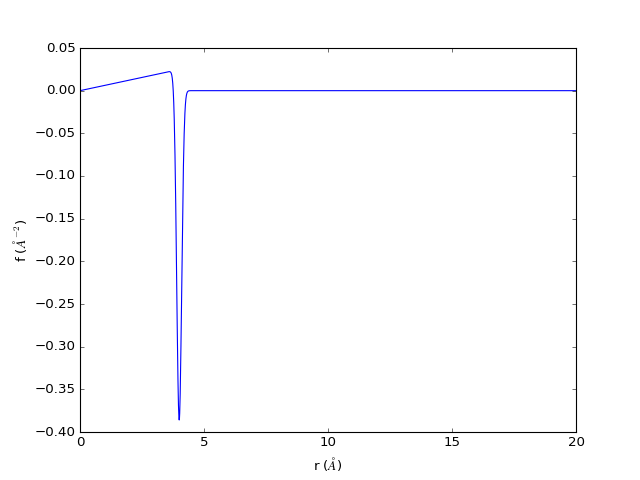

In [1]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from diffpy.mpdf import *

### Set all plots to be inline
%matplotlib notebook

### Create a MagStructure object
mstr = MagStructure()

### Create two atoms in the structure
mstr.atoms = np.array([[0,0,0],[4,0,0]])

### Create two spin vectors corresponding to the atoms. Let's make them antiferromagnetic.
S=np.array([0,0,1])
mstr.spins = np.array([S,-S])

### Create the MPDFcalculator object and load the magnetic structure into it
mc = MPDFcalculator(mstr)

### Calculate and plot the mPDF!
r,fr = mc.calc() # Use calc() if you want to extract the numerical results of the calculation
mc.plot() # Use plot() if you just want to plot the mPDF without extracting the numerical arrays.

Note that the negative peak at 4 Angstroms is due to the antiferromagnetic orientation of the spins. The sloping baseline at low-r is real and is a unique feature of the mPDF that is not found in the atomic PDF.

Just for fun, let's now make a copy of this structure but make the dimer ferromagnetic instead of antiferromagnetic.

<IPython.core.display.Javascript object>


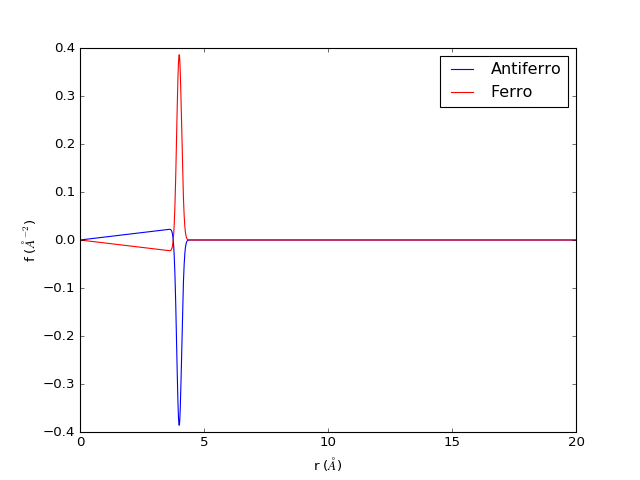

In [2]:
### make a copy of the magnetic structure
mstr2 = mstr.copy()

### Set the spins to be ferromagnetic
mstr2.spins = np.array([S,S])

### Create another mPDF calculator
mc2 = MPDFcalculator(mstr2)

### Calculate the mPDF
r2, fr2 = mc2.calc()

### Compare the antiferromagnetic and ferromagnetic mPDFs
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r,fr,'b-',label='Antiferro')
ax.plot(r2,fr2,'r-',label='Ferro')

ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend()

plt.show()

# Creating a magnetic structure from a CIF file using diffpy.Structure

This example will show how to use the MagSpecies class and additional features in the MagStructure class to quickly generate the atomic positions and spin vectors from a diffpy.Structure object. It will also show how to calculate the unnormalized mPDF, which is useful for comparison to and refinement against neutron total scattering data.

### Load the atomic structure from the CIF file

In [3]:
### First we have to import the loadStructure function from diffpy.Structure
from diffpy.Structure import loadStructure

### Now let's create a diffpy.Structure object from a CIF file for MnO. This has all the atomic information,
### but none of the magnetic information.
mno = loadStructure('MnO_cubic.cif')

### As a refresher, let's take a look at the mno structure object.
mno

[Mn2+ 0.000000 0.000000 0.000000 1.0000,
 Mn2+ 0.000000 0.500000 0.500000 1.0000,
 Mn2+ 0.500000 0.000000 0.500000 1.0000,
 Mn2+ 0.500000 0.500000 0.000000 1.0000,
 O2-  0.500000 0.500000 0.500000 1.0000,
 O2-  0.500000 0.000000 0.000000 1.0000,
 O2-  0.000000 0.500000 0.000000 1.0000,
 O2-  0.000000 0.000000 0.500000 1.0000]

### Create the MagSpecies object

In [4]:
### We will now create a MagSpecies object to extend the mno structure object.
mnoMag = MagSpecies()

### Load the mno structure and give the magnetic species a label
mnoMag.struc = mno
mnoMag.label = 'Mn2+'

### Now we need to tell it which atoms in MnO are magnetic. From the printed list in the previous cell,
### the magnetic Mn ions are the first four positions in the structure, so we provide the corresponding indices.
mnoMag.magIdxs = [0,1,2,3]

### Now we provide the magnetic propagation and basis vectors, which are known from previous neutron
### diffraction studies of MnO.
k = np.array([0.5,0.5,0.5])
s = np.array([1,-1,0]) # we won't worry about the magnitude of the basis vector for now
mnoMag.kvecs = np.array([k])
mnoMag.basisvecs = np.array([s])

### Now we provide information about the magnetic form factor. We tell the MagSpecies object the type of magnetic
### ion, and it looks up magnetic form factor in a table.
mnoMag.ffparamkey = 'Mn2'

### Create the MagStructure object

In [5]:
### Now we can create a MagStructure object and load mnoMag into it.
mnoMagStruc = MagStructure()
mnoMagStruc.loadSpecies(mnoMag)

### Now we will generate the atomic positions and spins. It is important to do the atoms first, since the
### spins are generated by applying the propagation and basis vectors to the atomic positions. These methods
### use the information contained in the atomic and magnetic structures to generate arrays of atomic positions
### and spin vectors.
mnoMagStruc.makeAtoms()
mnoMagStruc.makeSpins()

### And we make the magnetic form factor:
mnoMagStruc.makeFF()

Coordinates of atoms and spins for Mn2+
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for Mn2+ MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.


/home/ben/anaconda/envs/mpdfdev/lib/python2.7/site-packages/diffpy.Structure-1.3.2-py2.7.egg/diffpy/Structure/lattice.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if [a, b, c, alpha, beta, gamma, base] == 7*[None]:


<IPython.core.display.Javascript object>


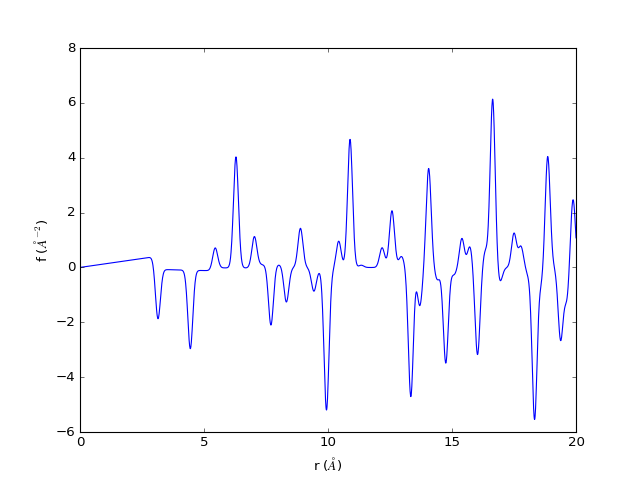

In [6]:
### Now we can create the mPDF calculator and load the magnetic structure
mc = MPDFcalculator()
mc.magstruc = mnoMagStruc

### Plot the mPDf
mc.plot()

# Creating a magnetic structure by defining your own unit cell

This example will show you how to create a magnetic structure from a unit cell that you define yourself. You will have to provide the lattice vectors, the positions of the magnetic atoms in the unit cell, and the magnetic moments corresponding to those atoms.

Coordinates of atoms and spins for 
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for  MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
Since you are not using a diffpy Structure object,
the spins are generated from the makeAtoms() method.
Please call that method if you have not already.


/home/ben/diffpy.mpdf/diffpy/mpdf/magstructure.py:158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ocoords = np.mgrid[-dim1:dim1+1, -dim2:dim2+1, -dim3:dim3+1].transpose().ravel().reshape((2*dim1+1)*(2*dim2+1)*(2*dim3+1), 3)


<IPython.core.display.Javascript object>


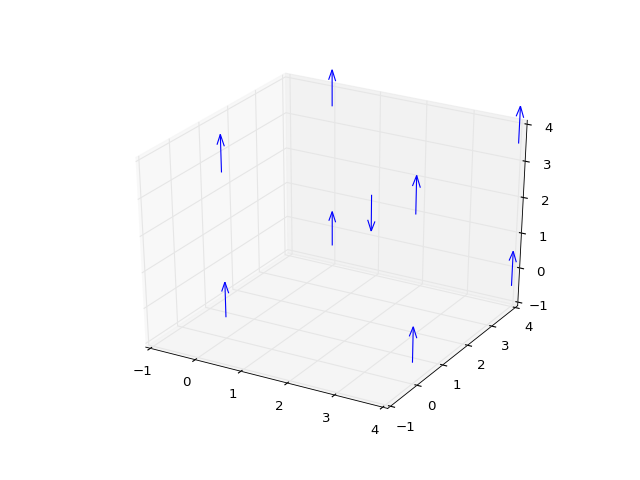

In [7]:
### Create the magnetic species and turn off the diffpy.structure option.
mspec = MagSpecies(useDiffpyStruc=False)

### Define the lattice vectors of the unit cell. Let's make a cubic unit cell.
a = 4.0
mspec.latVecs = np.array([[a,0,0], [0,a,0], [0,0,a]])

### Define the positions of the magnetic atoms in the unit cell (in fractional coordinates). Let's make
### a body-centered structure.
mspec.atomBasis = np.array([[0,0,0], [0.5,0.5,0.5]])

### Define the magnetic moments in the same order as the list of atoms. Let's make an antiferromagnet.
mspec.spinBasis = np.array([[0,0,1], [0,0,-1]])


### Create the magnetic structure object and load mspec.
mstruc = MagStructure()
mstruc.loadSpecies(mspec)
mstruc.makeAtoms()
mstruc.makeSpins()

### Let's visualize the first unit cell to make sure we have what we expect.
visAtoms = np.array([[0,0,0],[a,0,0],[0,a,0],[0,0,a],[a,a,0],
                     [a,0,a],[0,a,a],[a,a,a],[0.5*a,0.5*a,0.5*a]])
visSpins = mstruc.spinsFromAtoms(visAtoms, fractional=False)
mstruc.visualize(visAtoms, visSpins)

<IPython.core.display.Javascript object>


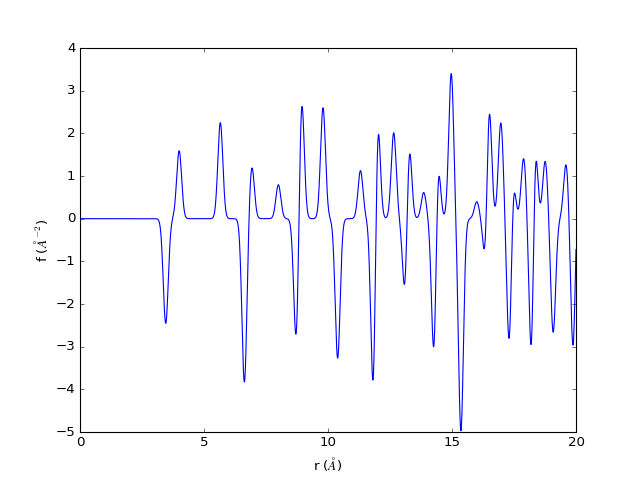

In [8]:
### Now we can set up the MPDFcalculator and plot the mPDF.
mc = MPDFcalculator(mstruc)
mc.plot()

# Creating a magnetic structure with multiple species: Simple ferrimagnet

We will create a ferrimagnetic structure to illustrate the use of multiple magnetic species within a single magnetic structure. Let's build another antiferromagnetic body-centered cubic structure but with two different spin species, one with a large moment and one with a small moment.

Coordinates of atoms and spins for big
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for big MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
Coordinates of atoms and spins for small
have not been loaded because they have not yet been
generated and/or do not match in shape.
Coordinates of atoms and spins for big
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for small MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for big MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
Since you are not using a diffpy Structure object,
the spins are generated from th

<IPython.core.display.Javascript object>


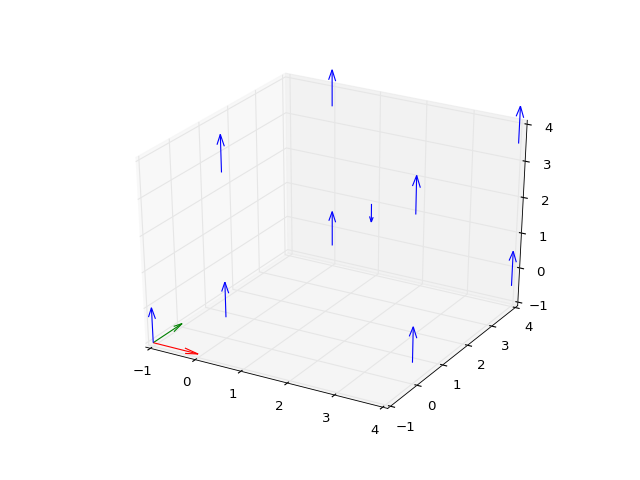

In [9]:
### Create the first magnetic species and turn off the diffpy.structure option.
mspec1 = MagSpecies(useDiffpyStruc=False)

### Define the lattice vectors of the unit cell. Let's make a cubic unit cell.
a = 4.0
mspec1.latVecs = np.array([[a,0,0],[0,a,0],[0,0,a]])

### Define the atomic position and magnetic moment.
mspec1.atomBasis = np.array([0,0,0])
mspec1.spinBasis = np.array([0,0,1])
mspec1.label = 'big' ### it is necessary to define unique identifying labels when you have multiple species

### Now make the other species, starting with mspec1 as a template
mspec2 = mspec1.copy()
mspec2.atomBasis = np.array([0.5,0.5,0.5])
mspec2.spinBasis = np.array([0,0,-0.5])
mspec2.label = 'small'
### Create the magnetic structure object and load the species.
mstruc = MagStructure()
mstruc.loadSpecies(mspec1)
mstruc.loadSpecies(mspec2)
mstruc.makeAll()

### Again, let's visualize the first unit cell to make sure we have what we expect.
visAtoms = np.array([[0,0,0],[a,0,0],[0,a,0],[0,0,a],[a,a,0],[a,0,a],[0,a,a],[a,a,a],[0.5*a,0.5*a,0.5*a]])
visSpins = mstruc.spinsFromAtoms(visAtoms, fractional=False)
mstruc.visualize(visAtoms, visSpins, showcrystalaxes=True, axesorigin=np.array([-1,-1,-1]))

{'small': 0, 'big': 3287}
[0, 3287]


<IPython.core.display.Javascript object>


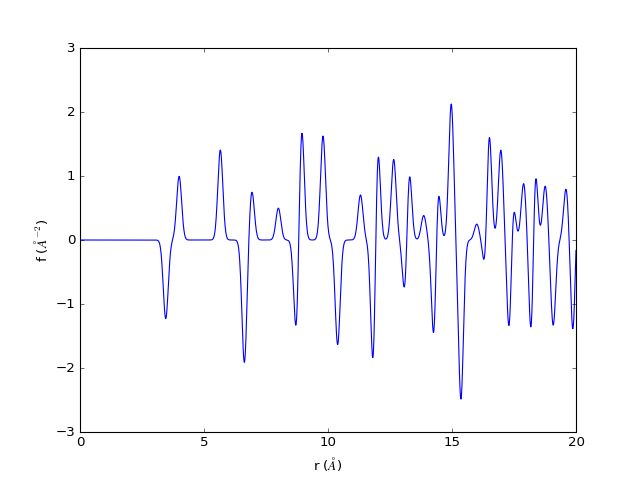

In [10]:
### Now we can set up the MPDFcalculator and plot the mPDF.
mc = MPDFcalculator(mstruc)

### Important: since we have two different magnetic species, we must be sure that the calculation
### uses an equivalent number of spins from each species as the "center" of the calculation.
### We do this by changing the calcList attribute of the MPDFcalculator, which is a list of the 
### indices of the atoms/spins to be used as the centers for the calculation. To find the starting
### index of each species, use the getSpeciesIdxs method on the magnetic structure.

mc.calcList = mstruc.getSpeciesIdxs().values()
print mc.calcList

### Now we can plot.
mc.plot()

# Creating more complex magnetic structures: One-dimensional spin helix

This example shows how to use multiple magnetic propagation vectors to create a non-collinear magnetic structure--in this case, a one-dimensional spin helix.

Running checks for helix MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.


<IPython.core.display.Javascript object>


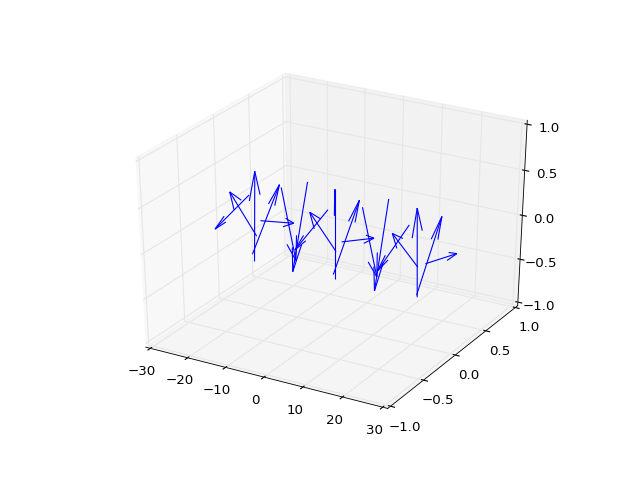

In [11]:
### We will load in a structure from a CIF file and modify it to simulate a 1-D material.
astruc = loadStructure("MnO_cubic.cif")
astruc.lattice.a = 3.0
astruc.lattice.b = 150.0
astruc.lattice.c = 150.0

### Create the magnetic species object.
helix = MagSpecies(astruc)

### Set up the magnetic propagation and basis vectors for a helical spin configuration.
k = np.array([np.sqrt(2)/10,0,0]) # make the period incommensurate with the lattice
helix.kvecs=np.array([k, -k])

Sk = 0.5*(np.array([0,0,1])+0.5j*np.array([0,1,0])) # j is the numpy symbol for the imaginary unit
helix.basisvecs = np.array([Sk,Sk.conj()])

### Populate with atoms and spins.
helix.rmaxAtoms = 70.0
helix.makeAtoms()
helix.makeSpins()
helix.label = 'helix'

### Create the magnetic structure object.
mstruc = MagStructure()
mstruc.loadSpecies(helix)

#### Visualize the spins.
x,y,z = mstruc.atoms.transpose()
mask = np.logical_and(z==0,np.logical_and(y==0,np.abs(x)<30))
visatoms = mstruc.atoms[mask]
visspins = spinsFromAtoms(mstruc, visatoms, fractional=False)
mstruc.visualize(visatoms, visspins)

<IPython.core.display.Javascript object>


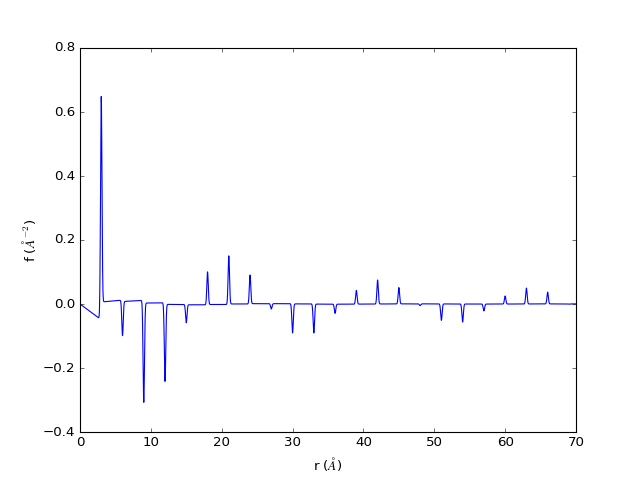

In [12]:
### Now plot the mPDF.
mc = MPDFcalculator(mstruc)
mc.rmax=70.0

mc.plot()

# Exploring some of the additional parameters in the mPDF

Now we will take a look at some of the other mPDF parameters that can be adjusted, including:
- Qmin and Qmax to simulate experimental conditions.
- Parameters that dampen and/or broaden the mPDF, simulating the effects of thermal motion and instrumental resolution.
- "Ordered" scale factor corresponding to the magnitude of the locally ordered moment, and "paramagnetic" scale factor which depends only on the magnitude and spatial extent of a single localized moment, not any correlations between moments.
- The r-range for the calculation.

For this, we will create the antiferromagnetic MnO structure again.

In [13]:
### Create the diffpy structure, MagSpecies, and MagStructure
mno = loadStructure('MnO_cubic.cif')

mnoMag = MagSpecies(mno, magIdxs=[0,1,2,3], label='Mn2+', ffparamkey='Mn2')
mnoMag.kvecs = np.array([0.5,0.5,0.5])
mnoMag.basisvecs = np.array([1,-1,0])

mnoMagStruc = MagStructure()
mnoMagStruc.loadSpecies(mnoMag)
mnoMagStruc.makeAll()

Coordinates of atoms and spins for Mn2+
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for Mn2+ MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
Running checks for Mn2+ MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.


Now we'll make the mPDF calculator along with several slightly modified copies so that we can compare them.

<IPython.core.display.Javascript object>


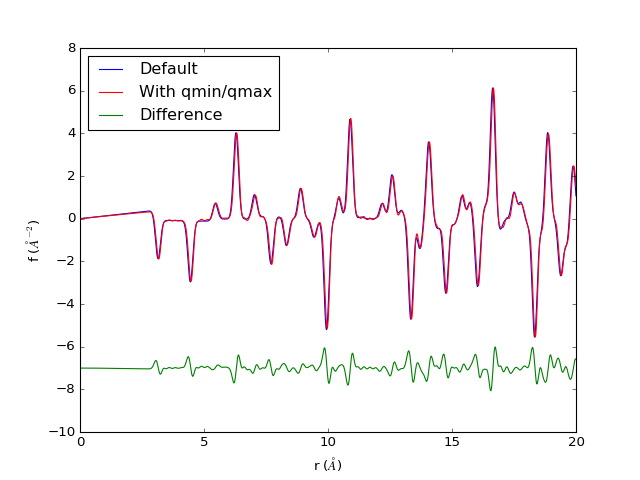

In [14]:
### Default mPDF calculator
mc = MPDFcalculator(mnoMagStruc)
r, fr, dr = mc.calc(both=True)

### Adjust qmin and qmax to simulate termination ripples
mcQ = mc.copy()
mcQ.qmin, mcQ.qmax = 0.1,25
rq,frq = mcQ.calc()
sclfactor = fr.max()/frq.max()
frq *= sclfactor

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, fr, 'b-', label='Default')
ax.plot(rq, frq, 'r-', label='With qmin/qmax')
ax.plot(r, frq-fr-7, 'g-', label='Difference')

ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


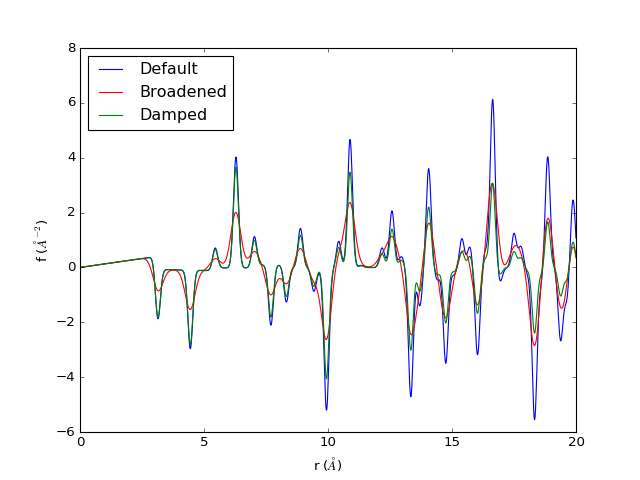

In [15]:
### Change the intrinsic mPDF peak width to simulate thermal motion
### and/or instrumental resolution effects.
mcB = mc.copy()
mcB.gaussPeakWidth = 0.2 # in Angstroms; default is 0.1
rB, frB = mcB.calc()

### Include a damping factor to simulate a finite correlation length
### and/or instrumental resolution effects.
mcD = mc.copy()
mcD.dampRate = 0.1 # in inverse Angstroms
rD, frD = mcD.calc()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, fr, 'b-', label='Default')
ax.plot(rB, frB, 'r-', label='Broadened')
ax.plot(rD, frD, 'g-', label='Damped')
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'f ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


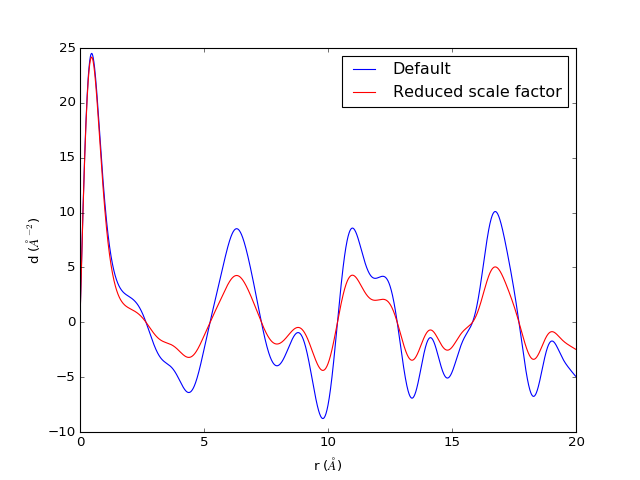

In [16]:
### Change the ordered scale factor relative to the paramagnetic scale factor, simulating
### a reduction in the size of the ordered moment relative to the total local moment.
mcS = mc.copy()
mcS.ordScale = 0.5*mc.ordScale
rS, frS, drS = mcS.calc(both=True) # both the normalized and unnormalized mPDF

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, dr, 'b-', label='Default')
ax.plot(rS, drS, 'r-', label='Reduced scale factor')
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'd ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

Running checks for Mn2+ MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.


<IPython.core.display.Javascript object>


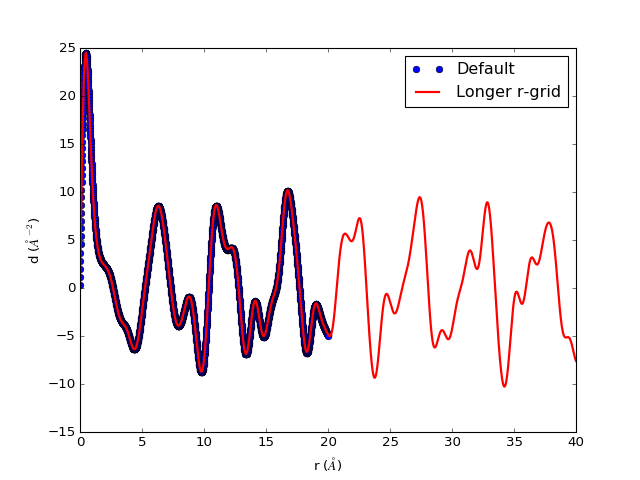

In [17]:
### Change the r-range for the calculation from 20 Angstroms (default) to 40.
mcL = mc.copy()
mcL.rmax = 40 # in Angstroms

### Since the r-range is longer, we also need to re-generate the atoms and spins
### to fill a sphere of at least radius 40 Angstroms. The code below does this.
mcL.magstruc.species['Mn2+'].rmaxAtoms = 50
mcL.magstruc.makeAll()

rL,frL,drL = mcL.calc(both=True)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(r, dr, 'bo', label='Default')
ax.plot(rL, drL, 'r-', label='Longer r-grid',lw=2)
ax.set_xlabel(r'r ($\AA$)')
ax.set_ylabel(r'd ($\AA^{-2}$)')

plt.legend(loc='best')
plt.show()

# Simple example of an mPDF fit

Here, we will provide an example of doing a very basic mPDF fit to actual experimental data taken on MnO. The initial structural PDF was refined using PDFgui, and now we use the residual of that structural fit as the dataset against which the mPDF will be refined. To keep things simple, we will just refine the scale factors here.

Coordinates of atoms and spins for Mn2+
have not been loaded because they have not yet been
generated and/or do not match in shape.
Running checks for Mn2+ MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
Running checks for Mn2+ MagSpecies object...

All MagSpecies() checks passed. No obvious problems found.

Running checks for  MagStructure object...

All MagStructure checks passed. No obvious problems found.
(array([ 3.75623147,  1.14768791]), 3)


<IPython.core.display.Javascript object>


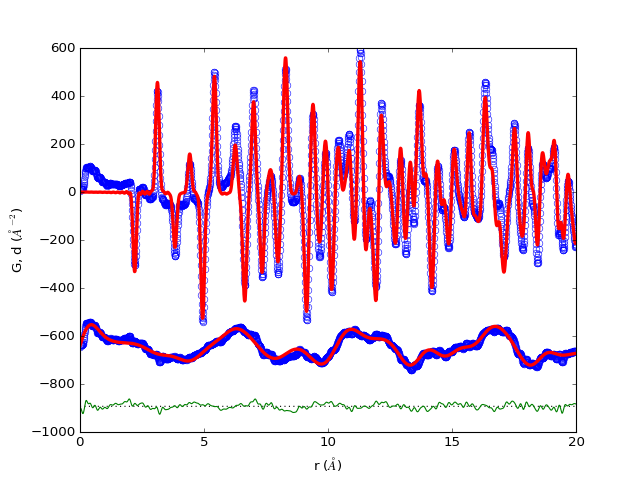

In [18]:
# Create the structure from our cif file, update the lattice according to the PDFgui fit.
structureFile = "MnO_R-3m.cif" # note we are not using the cubic structure now
mnostructure = loadStructure(structureFile)
lat = mnostructure.lattice
lat.a, lat.b, lat.c = 3.1505626, 3.1505626, 7.5936979 # these are the refined values from PDFgui

### Create the Mn2+ magnetic species.
msp = MagSpecies(struc=mnostructure, label='Mn2+', ffparamkey='Mn2')
msp.magIdxs = [0,1,2] # these indices correspond to the Mn atoms in the rhombohedral unit cell
msp.basisvecs = 2.5*np.array([1,0,0]) # spin direction in coordinate system of rhombohedral structure
msp.kvecs = np.array([0,0,1.5]) # propagation vector in the rhombohedral structure

### Create and prep the magnetic structure.
mstr = MagStructure()
mstr.loadSpecies(msp)
mstr.makeAll()

### Set up the mPDF calculator.
mc = MPDFcalculator(magstruc=mstr)


# Load the data
PDFfitFile = 'MnOfit_PDFgui.fgr'
rexp, Drexp = getDiffData([PDFfitFile])
mc.rmin = rexp.min()
mc.rmax = rexp.max()

# Do the refinement
from scipy.optimize import leastsq

def residual(p,yexp,mcalc):
    mcalc.paraScale,mcalc.ordScale=p
    return yexp-mcalc.calc(both=True)[2]

p0 = [5.0,3.0] # initial parameter values; paraScale, ordScale
pOpt = leastsq(residual, p0, args=(Drexp,mc))
print pOpt

fit = mc.calc(both=True)[2]
mdiff = Drexp - fit

### Plot the results.

# Grab full structural PDF data for plotting.
PDFdata = np.loadtxt(PDFfitFile,unpack=True,skiprows=12)
r, grcalc, gdiff = PDFdata[0], PDFdata[1], PDFdata[3]
gobs = gdiff + grcalc
offset1 = 1.2*gobs.min()
offset2 = offset1 - 8*mdiff.max()

# Make the figure.
fig = plt.figure()
ax = fig.add_subplot(111)
mask = (r <= mc.rmax)
ax.plot(r[mask],gobs[mask],marker='o',mfc='none',mec='b',linestyle='none')
ax.plot(r[mask],grcalc[mask],'r-',lw=3)
ax.plot(r[mask],gdiff[mask]+offset1,marker='o',mfc='none',mec='b',linestyle='none')
ax.plot(rexp,fit+offset1,'r-',lw=3)
ax.plot(rexp,np.zeros_like(rexp)+offset2,'k:')
ax.plot(rexp,mdiff+offset2,'g-')
ax.set_xlim(xmin=mc.rmin,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G, d ($\AA^{-2}$)')

plt.show()

In the plot above, the top set of curves gives the total experimental PDF (blue circles) with the refined structural PDF (red curve). The lower set of curves gives the structural PDF fit residual (blue circles), which contains the experimental mPDF, with the refined mPDF overlaid (red curve). The lower green curve gives the combined PDF+mPDF fit residual.

In [19]:
plt.close('all')

### This concludes the introductory tutorial for diffpy.mpdf. Try out the other example scripts to gain more familiarity with the package, such as how to do a simultaneous co-refinement of the PDF and mPDF. Then go on and use these tools for your own data!